## PART 1: Data Cleaning and Feature Engineering

In this notebook, I will walkthrough the process of inputting SET data file and generating a number of features, including the classification predictions.
The purpose is to get data ready for model building in the next part.

In [1]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
import matplotlib.pyplot as plt

from datetime import datetime

In [2]:
# Read SET index price file & rename columns
# This file contains SET index from 2001 to the end of 2020 retrieved from Thomson Reuter Datastream
# Shape of this dataframe = (5220, 2)
# Properties: 1) Date (datetime64[ns]); 2) Close (float64)

SET_IDX_PRICE = pd.read_csv('data/SET/SET_Price.csv', parse_dates = True)
SET_IDX_PRICE = SET_IDX_PRICE.rename(columns = {'Name': 'Date', 'BNGKSET_P': 'Close'})
SET_IDX_PRICE['Date'] = pd.to_datetime(SET_IDX_PRICE['Date'])
SET_IDX_PRICE.head()

,Date,Close
0,2001-01-01,269.19
1,2001-01-02,269.19
2,2001-01-03,272.03
3,2001-01-04,278.75
4,2001-01-05,286.76


In [3]:
# Read SET index volume file & rename columns
# This file contains volume traded associated with SET index from 2001 to the end of 2020 retrieved from Thomson Reuter Datastream
# Shape of this dataframe = (5220, 2)
# Properties: 1) Date (datetime64[ns] ); 2) Volume (float64)

# Caveat: On some rows, the volume shows NaN because there is no trade occurred (for example, holidays)

SET_IDX_VOL = pd.read_csv('data/SET/SET_VO.csv', parse_dates = True)
SET_IDX_VOL = SET_IDX_VOL.rename(columns = {'Code': 'Date', 'BNGKSET(VO)': 'Volume'})
SET_IDX_VOL['Date'] = pd.to_datetime(SET_IDX_VOL['Date'])
SET_IDX_VOL.head()

,Date,Volume
0,2001-01-01,NaN
1,2001-01-02,NaN
2,2001-01-03,90861.75
3,2001-01-04,329329.70
4,2001-01-05,344688.40


In [4]:
# Time to merge the dataframe!
# Notice that the shape of df is now (5220, 3). That is great because we do not lose any observations from joining dfs
# In addition, I remove all the rows with missing volume (e.g. holidays)
# Finally, we get the SET_IDX of shape (4882, 3)

SET_IDX = pd.merge(SET_IDX_PRICE, SET_IDX_VOL, how='inner', on ='Date')
SET_IDX = SET_IDX.dropna()
SET_IDX = SET_IDX[SET_IDX['Volume'] > 0]
SET_IDX.head()

,Date,Close,Volume
2,2001-01-03,272.03,90861.75
3,2001-01-04,278.75,329329.70
4,2001-01-05,286.76,344688.40
5,2001-01-08,295.84,934483.00
6,2001-01-09,298.37,1361737.00


### Feature Generation 1: find 14-day SMA and EMA to extract the trend from the data
Source: https://www.datacamp.com/community/tutorials/moving-averages-in-pandas  
Source: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html

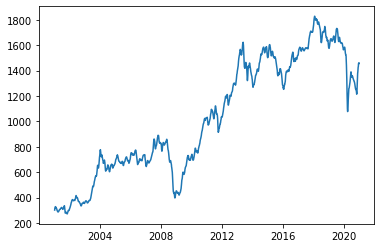

In [9]:
import matplotlib.pyplot as plt
MA_14 = SET_IDX.loc[:,'Close'].rolling(window=14).mean()
fig, ax = plt.subplots()
ax.plot(SET_IDX['Date'], MA_14)

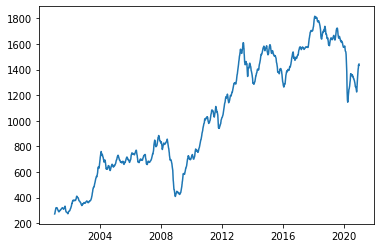

In [10]:
import matplotlib.pyplot as plt
EMA = SET_IDX.loc[:, 'Close'].ewm(span=19, adjust=False).mean()
fig, ax = plt.subplots()
ax.plot(SET_IDX['Date'], EMA)

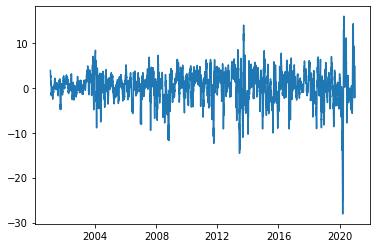

In [11]:
MA_14_diff = MA_14.diff()
fig, ax = plt.subplots()
ax.plot(SET_IDX['Date'], MA_14_diff)

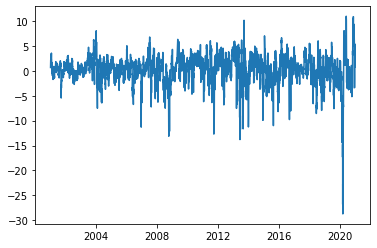

In [12]:
EMA_diff = EMA.diff()
fig, ax = plt.subplots()
ax.plot(SET_IDX['Date'], EMA_diff)

#### Observations
- Trend data using either MA or EMA are non-stationary (increase over time). This will cause trouble for our prediction esp when we predict in the future.
- First-differenced MA or EMA seems stationary because they fluctuated around zeros. 
- Notice that in some period, MA and EMA swing wildly, and we need to address that.

In [13]:
## Here, we generate SMA of 3 periods, 5 periods and 14 periods, together with EMA of alpha around 0.9.
## We use first-differenced variables into our model.

MA_3 = SET_IDX.loc[:,'Close'].rolling(window=3).mean()
MA_5 = SET_IDX.loc[:,'Close'].rolling(window=5).mean()
MA_14 = SET_IDX.loc[:,'Close'].rolling(window=14).mean()
EMA = SET_IDX.loc[:, 'Close'].ewm(span=19, adjust=False).mean()

SET_IDX['MA_diff_3'] = MA_3.diff()
SET_IDX['MA_diff_5'] = MA_5.diff()
SET_IDX['MA_diff_14'] = MA_14.diff()
SET_IDX['EMA_diff'] = EMA.diff()

SET_IDX.head()

,Date,Close,Volume,MA_diff_3,MA_diff_5,MA_diff_14,EMA_diff
2,2001-01-03,272.03,90861.75,NaN,NaN,NaN,NaN
3,2001-01-04,278.75,329329.70,NaN,NaN,NaN,0.672000
4,2001-01-05,286.76,344688.40,NaN,NaN,NaN,1.405800
5,2001-01-08,295.84,934483.00,7.936667,NaN,NaN,2.173220
6,2001-01-09,298.37,1361737.00,6.540000,NaN,NaN,2.208898


### Feature Generation 2: find MACD to account for trend and momentum
Source: https://www.finnomena.com/daddy-trader/macd/

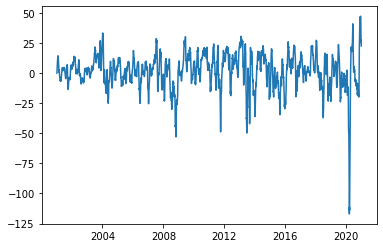

In [14]:
## We use the default parameters of 12 and 26 in MACD calculation here.
EMA_12 = SET_IDX.loc[:, 'Close'].ewm(span=12, adjust=False).mean()
EMA_26 = SET_IDX.loc[:, 'Close'].ewm(span=26, adjust=False).mean()
MACD = EMA_12 - EMA_26

fig, ax = plt.subplots()
ax.plot(SET_IDX['Date'], MACD)

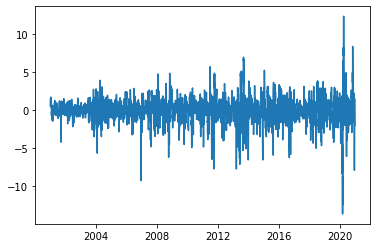

In [15]:
fig, ax = plt.subplots()
ax.plot(SET_IDX['Date'], MACD.diff())

#### Observations
- If we use just EMA(12) - EMA(26), what we observed is short-run fluctuation from medium-run trend. In other words, by subtracting out the trend, what fluctuations do we get.
- If we use delta(EMA(12) - EMA(26)) instead, what we observed is the signed speed of price changes, or simply momentum. This would capture how fast/slow EMA(12) and EMA(26) converged toward each other and diverged from each other.

In [16]:
# Feature Generation 2: Find MACD and RSI to account for the trend strength

EMA_12 = SET_IDX.loc[:, 'Close'].ewm(span=12, adjust=False).mean()
EMA_26 = SET_IDX.loc[:, 'Close'].ewm(span=26, adjust=False).mean()
SET_IDX['MACD'] = EMA_12 - EMA_26
SET_IDX['MACD_diff'] = SET_IDX['MACD'].diff()
SET_IDX.head()

,Date,Close,Volume,MA_diff_3,MA_diff_5,MA_diff_14,EMA_diff,MACD,MACD_diff
2,2001-01-03,272.03,90861.75,NaN,NaN,NaN,NaN,0.000000,NaN
3,2001-01-04,278.75,329329.70,NaN,NaN,NaN,0.672000,0.536068,0.536068
4,2001-01-05,286.76,344688.40,NaN,NaN,NaN,1.405800,1.588930,1.052862
5,2001-01-08,295.84,934483.00,7.936667,NaN,NaN,2.173220,3.120045,1.531115
6,2001-01-09,298.37,1361737.00,6.540000,NaN,NaN,2.208898,4.485904,1.365859


### Feature Generation 3: find RSI to account for momentum
Source: https://www.investopedia.com/terms/r/rsi.asp

In [25]:
## Define a custom function for calculating RSI
## Source: https://stackoverflow.com/a/29400434

def RSI(close, window_length, SMA = False):
    ''' Arguments: close (Pandas series object, indicating the price inputted to calculate RSI)
                         window_length (the length needed to calculate simple moving average or input to the parameter of alpha in EMA)
                         SMA (if True, use SMA; otherwise, use EMA)
        Returns: Pandas series containing RSI (value between 0 to 100) except for the first entry outputting the string 'NaN'
                     because we lose one observation in calculating first-order difference in close
    '''
    
    delta = close.diff()
    # Take out the first row, be careful!
    delta = delta[1:]
    
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0
    
    NaN = float("NaN")
    
    if SMA == False:
        
        # Calculate Exponential Moving Average
        # Note that alpha = 2/(window_length + 1)
        roll_up1 = up.ewm(span=window_length).mean()
        roll_down1 = down.abs().ewm(span=window_length).mean()
        
        # Calculate the RSI based on EWMA
        RS1 = roll_up1 / roll_down1
        RSI1 = 100.0 - (100.0 / (1.0 + RS1))
        return pd.concat([pd.Series([NaN]), RSI1])

    else:
        # Calculate the SMA
        roll_up2 = up.rolling(window_length).mean()
        roll_down2 = down.abs().rolling(window_length).mean()
        
        # Calculate the RSI based on SMA
        RS2 = roll_up2 / roll_down2
        RSI2 = 100.0 - (100.0 / (1.0 + RS2))
        return pd.concat([pd.Series([NaN]), RSI2])

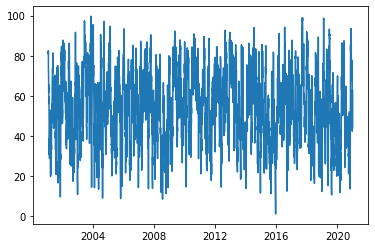

In [27]:
# 14 is the default parameter.
RSI_SMA = RSI(SET_IDX.loc[:, 'Close'], 14, SMA = True)
fig, ax = plt.subplots()
ax.plot(SET_IDX['Date'], RSI_SMA)

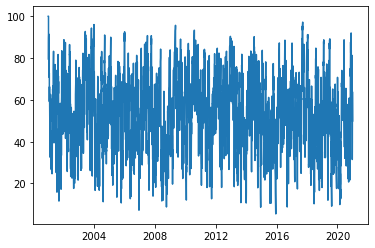

In [28]:
# 14 is the default parameter.
RSI_EMA = RSI(SET_IDX.loc[:, 'Close'], 14, SMA = False)
fig, ax = plt.subplots()
ax.plot(SET_IDX['Date'], RSI_EMA)

#### Observations
- RSI measures the proportion of average gain against average loss over the window length. RSI ranges between 0 and 100.
- From illustration, RSI looks nice as it is clustered around 50, and roughly and equally distributed to both sides.

In [29]:
SET_IDX['RSI'] = RSI(SET_IDX.loc[:, 'Close'], 14, SMA = True)
SET_IDX.head()

,Date,Close,Volume,MA_diff_3,MA_diff_5,MA_diff_14,EMA_diff,MACD,MACD_diff,RSI
2,2001-01-03,272.03,90861.75,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
3,2001-01-04,278.75,329329.70,NaN,NaN,NaN,0.672000,0.536068,0.536068,NaN
4,2001-01-05,286.76,344688.40,NaN,NaN,NaN,1.405800,1.588930,1.052862,NaN
5,2001-01-08,295.84,934483.00,7.936667,NaN,NaN,2.173220,3.120045,1.531115,NaN
6,2001-01-09,298.37,1361737.00,6.540000,NaN,NaN,2.208898,4.485904,1.365859,NaN


### Feature Generation 4: direct momentum measures


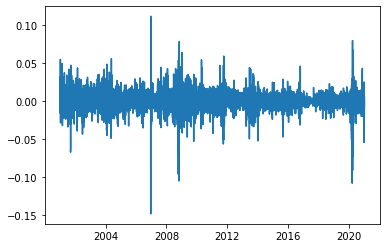

In [30]:
MOM1 = SET_IDX.loc[:, 'Close'].pct_change(periods = 1)
MOM3 = SET_IDX.loc[:, 'Close'].pct_change(periods = 3)
MOM5 = SET_IDX.loc[:, 'Close'].pct_change(periods = 5)
MOM14 = SET_IDX.loc[:, 'Close'].pct_change(periods = 14)

fig, ax = plt.subplots()
ax.plot(SET_IDX['Date'], MOM1)

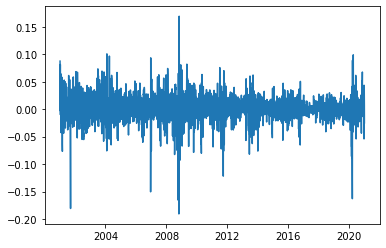

In [31]:
fig, ax = plt.subplots()
ax.plot(SET_IDX['Date'], MOM3)

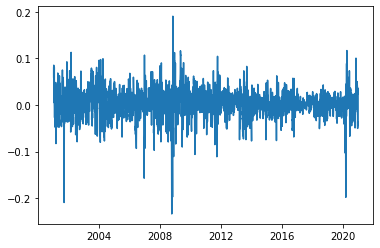

In [32]:
fig, ax = plt.subplots()
ax.plot(SET_IDX['Date'], MOM5)

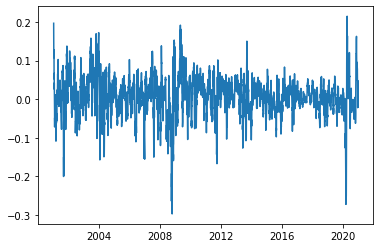

In [33]:
fig, ax = plt.subplots()
ax.plot(SET_IDX['Date'], MOM14)

#### Observations
- Momentum is clustered around zero, implying that percentage change of price (return) on average is around zero.
- There are tail risks (usually negative) associated with investing where we could see extremely negative return in a few periods.

In [34]:
# Feature Generation 4: Momentum (use 1, 3, 5, 14 days)
SET_IDX['MOM1'] = SET_IDX.loc[:, 'Close'].pct_change(periods = 1)
SET_IDX['MOM3'] = SET_IDX.loc[:, 'Close'].pct_change(periods = 3)
SET_IDX['MOM5'] = SET_IDX.loc[:, 'Close'].pct_change(periods = 5)
SET_IDX['MOM14'] = SET_IDX.loc[:, 'Close'].pct_change(periods = 14)

SET_IDX.head()

,Date,Close,Volume,MA_diff_3,MA_diff_5,MA_diff_14,EMA_diff,MACD,MACD_diff,RSI,MOM1,MOM3,MOM5,MOM14
2,2001-01-03,272.03,90861.75,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
3,2001-01-04,278.75,329329.70,NaN,NaN,NaN,0.672000,0.536068,0.536068,NaN,0.024703,NaN,NaN,NaN
4,2001-01-05,286.76,344688.40,NaN,NaN,NaN,1.405800,1.588930,1.052862,NaN,0.028735,NaN,NaN,NaN
5,2001-01-08,295.84,934483.00,7.936667,NaN,NaN,2.173220,3.120045,1.531115,NaN,0.031664,0.087527,NaN,NaN
6,2001-01-09,298.37,1361737.00,6.540000,NaN,NaN,2.208898,4.485904,1.365859,NaN,0.008552,0.070386,NaN,NaN


### Feature Generation 5: Commodity channel index (CCI)
Source: https://school.stockcharts.com/doku.php?id=technical_indicators:commodity_channel_index_cci

In [35]:
# Feature Generation 5: CCI
# Define custom function named CCI
def CCI(close, window_length, epsilon = 10**(-7)): 
    ''' This function only uses close price in calculating CCI, which could be an alternative version to (high + low + close)/3
        Arguments: close (Pandas series object, indicating the price inputted to calculate CCI)
                         window_length (the length needed to calculate simple moving average and standard deviation)
                         epsilon (prevent numerical problems where the denominator is very close to zero, default = 10^-7)
        Returns: Pandas series containing CCI
    '''
    CCI = pd.Series((close - close.rolling(window_length).mean()) / (epsilon + 0.015 * close.rolling(window_length).std())) 

    return CCI

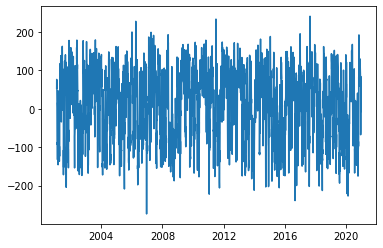

In [37]:
# We use default parameter of 20
CCI_20 = CCI(SET_IDX.loc[:, 'Close'], 20)
fig, ax = plt.subplots()
ax.plot(SET_IDX['Date'], CCI_20)

#### Observations
- CCI is clustered around zero, and roughly evenly distributed to both negative and positive sides.
- The good thing about CCI is that we see less of outlier observations (compared to previous ones). That is because we account for the price change by recent volatilities. In other words, an equal price change in low-volatility period and high-volatility period would be discounted differently.

In [38]:
SET_IDX['CCI_20'] = CCI(SET_IDX.loc[:, 'Close'], 20)
# Just add another feature to account for 14-day volatilities
SET_IDX['STD_14'] = SET_IDX.loc[:, 'Close'].rolling(window = 14).std()
SET_IDX.head(5)

,Date,Close,Volume,MA_diff_3,MA_diff_5,MA_diff_14,EMA_diff,MACD,MACD_diff,RSI,MOM1,MOM3,MOM5,MOM14,CCI_20,STD_14
2,2001-01-03,272.03,90861.75,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2001-01-04,278.75,329329.70,NaN,NaN,NaN,0.672000,0.536068,0.536068,NaN,0.024703,NaN,NaN,NaN,NaN,NaN
4,2001-01-05,286.76,344688.40,NaN,NaN,NaN,1.405800,1.588930,1.052862,NaN,0.028735,NaN,NaN,NaN,NaN,NaN
5,2001-01-08,295.84,934483.00,7.936667,NaN,NaN,2.173220,3.120045,1.531115,NaN,0.031664,0.087527,NaN,NaN,NaN,NaN
6,2001-01-09,298.37,1361737.00,6.540000,NaN,NaN,2.208898,4.485904,1.365859,NaN,0.008552,0.070386,NaN,NaN,NaN,NaN


In [40]:
# Just for debugging on how shift method works ;)
SET_IDX.shift(1).head()

,Date,Close,Volume,MA_diff_3,MA_diff_5,MA_diff_14,EMA_diff,MACD,MACD_diff,RSI,MOM1,MOM3,MOM5,MOM14,CCI_20,STD_14
2,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2001-01-03,272.03,90861.75,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2001-01-04,278.75,329329.70,NaN,NaN,NaN,0.67200,0.536068,0.536068,NaN,0.024703,NaN,NaN,NaN,NaN,NaN
5,2001-01-05,286.76,344688.40,NaN,NaN,NaN,1.40580,1.588930,1.052862,NaN,0.028735,NaN,NaN,NaN,NaN,NaN
6,2001-01-08,295.84,934483.00,7.936667,NaN,NaN,2.17322,3.120045,1.531115,NaN,0.031664,0.087527,NaN,NaN,NaN,NaN


### Feature Generation 6: Volume Agent
Source: Predicting Stock Prices Using Technical Analysis and Machine Learning written by Jan Ivar Larsen

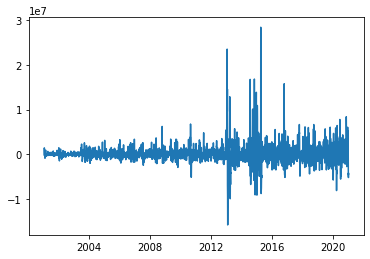

In [41]:
# We will use default parameters used in the above paper (2, 14)
VA_2 = SET_IDX.loc[:,'Volume'].rolling(window=2).mean()
VA_14 = SET_IDX.loc[:,'Volume'].rolling(window=14).mean()

fig, ax = plt.subplots()
ax.plot(SET_IDX['Date'], VA_2 - VA_14)

#### Observations
- Note that volume indicator is just supporting indicator. To confirm that there is enough volume to support momentum and trend changes.
- We could see tailed observations in volume change. Does not matter as long as we flatten it out to be dummy variable.

In [43]:
VA_2 = SET_IDX.loc[:,'Volume'].rolling(window=2).mean()
VA_14 = SET_IDX.loc[:,'Volume'].rolling(window=14).mean()
VA_diff = VA_2 - VA_14

# Encode dummy variable using apply method
SET_IDX['Volume_Agent'] = VA_diff.apply(lambda x: 1 if x > 0 else 0)


In [46]:
SET_IDX['Volume_Agent'].describe()
# Interesting to see on average, what is proportion of VA_2 > VA_14 over all observations (answer: mean is not different from 0.5)

count    4882.000000
mean        0.465998
std         0.498894
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: Volume_Agent, dtype: float64

### Time to generate the predictions and split observations to Train, Validate, Test split
The below visualization shows the framework of thought (I took it from a Medium article)

In [47]:
%%HTML
<img src = "./Prediction_scheme.jpeg", width = 400 />

In [48]:
## Time to generate y: the prediction is separated into three classes:
## Up (1): if the price in prediction period (e.g. 1, 3, 5, 14 days) increases by more than 0.5% of today index
## Down (-1): if the price in prediction period (e.g. 1, 3, 5, 14 days) decreases by more than 0.5% of today index
## Sideway (0): if the price in prediction period (e.g. 1, 3, 5, 14 days) is between -0.5% to 0.5% of today index

# The number 0.5% comes from the paper "Performance of technical trading rules: evidence from Southeast Asian stock markets"
# written by Piyapas Tharavanij*, Vasan Siraprapasiri and Kittichai Rajchamaha

def generatePrediction(close, prediction_interval):
    ''' Arguments: close (Pandas series containing the close price)
        Returns: Pandas series containing true Y
    '''
    series = np.where(close.shift(-prediction_interval) > 1.005*close, 1, 
                                    np.where(close.shift(-prediction_interval) < 0.995*close, -1, 0))
    return series

In [49]:
SET_IDX['Y_1'] = generatePrediction(SET_IDX.loc[:, 'Close'], 1)
SET_IDX['Y_3'] = generatePrediction(SET_IDX.loc[:, 'Close'], 3)
SET_IDX['Y_5'] = generatePrediction(SET_IDX.loc[:, 'Close'], 5)
SET_IDX['Y_14'] = generatePrediction(SET_IDX.loc[:, 'Close'], 14)
SET_IDX.head(10)

,Date,Close,Volume,MA_diff_3,MA_diff_5,MA_diff_14,EMA_diff,MACD,MACD_diff,RSI,...,MOM3,MOM5,MOM14,CCI_20,STD_14,Volume_Agent,Y_1,Y_3,Y_5,Y_14
2,2001-01-03,272.03,90861.75,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,1,1,1,1
3,2001-01-04,278.75,329329.70,NaN,NaN,NaN,0.672000,0.536068,0.536068,NaN,...,NaN,NaN,NaN,NaN,NaN,0,1,1,1,1
4,2001-01-05,286.76,344688.40,NaN,NaN,NaN,1.405800,1.588930,1.052862,NaN,...,NaN,NaN,NaN,NaN,NaN,0,1,1,1,1
5,2001-01-08,295.84,934483.00,7.936667,NaN,NaN,2.173220,3.120045,1.531115,NaN,...,0.087527,NaN,NaN,NaN,NaN,0,1,0,1,1
6,2001-01-09,298.37,1361737.00,6.540000,NaN,NaN,2.208898,4.485904,1.365859,NaN,...,0.070386,NaN,NaN,NaN,NaN,0,-1,1,1,1
7,2001-01-10,293.65,684156.20,2.296667,4.324,NaN,1.516008,5.128375,0.642472,NaN,...,0.024027,0.079477,NaN,NaN,NaN,0,0,1,1,1
8,2001-01-11,295.06,734011.40,-0.260000,3.262,NaN,1.505407,5.685772,0.557397,NaN,...,-0.002637,0.058511,NaN,NaN,NaN,0,1,1,1,1
9,2001-01-12,311.25,1536920.00,4.293333,4.898,NaN,2.973867,7.349193,1.663422,NaN,...,0.043168,0.085402,NaN,NaN,NaN,0,1,1,1,1
10,2001-01-15,317.51,1541838.00,7.953333,4.334,NaN,3.302480,9.068066,1.718872,NaN,...,0.081253,0.073249,NaN,NaN,NaN,0,-1,-1,0,1
11,2001-01-16,308.42,800220.10,4.453333,2.010,NaN,2.063232,9.586292,0.518227,NaN,...,0.045279,0.033683,NaN,NaN,NaN,0,1,1,1,1


### Extra Feature: Dummy feature
I intend to come up with this feature to build a benchmark model. Basically, it is just the lagged value of y.

In [52]:
SET_IDX['Y_N_1'] = generatePrediction(SET_IDX.loc[:, 'Close'], -1) # Opposite of shift function because we use negative number

In [53]:
SET_IDX.head(10)

,Date,Close,Volume,MA_diff_3,MA_diff_5,MA_diff_14,EMA_diff,MACD,MACD_diff,RSI,...,MOM5,MOM14,CCI_20,STD_14,Volume_Agent,Y_1,Y_3,Y_5,Y_14,Y_N_1
2,2001-01-03,272.03,90861.75,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,0,1,1,1,1,0
3,2001-01-04,278.75,329329.70,NaN,NaN,NaN,0.672000,0.536068,0.536068,NaN,...,NaN,NaN,NaN,NaN,0,1,1,1,1,-1
4,2001-01-05,286.76,344688.40,NaN,NaN,NaN,1.405800,1.588930,1.052862,NaN,...,NaN,NaN,NaN,NaN,0,1,1,1,1,-1
5,2001-01-08,295.84,934483.00,7.936667,NaN,NaN,2.173220,3.120045,1.531115,NaN,...,NaN,NaN,NaN,NaN,0,1,0,1,1,-1
6,2001-01-09,298.37,1361737.00,6.540000,NaN,NaN,2.208898,4.485904,1.365859,NaN,...,NaN,NaN,NaN,NaN,0,-1,1,1,1,-1
7,2001-01-10,293.65,684156.20,2.296667,4.324,NaN,1.516008,5.128375,0.642472,NaN,...,0.079477,NaN,NaN,NaN,0,0,1,1,1,1
8,2001-01-11,295.06,734011.40,-0.260000,3.262,NaN,1.505407,5.685772,0.557397,NaN,...,0.058511,NaN,NaN,NaN,0,1,1,1,1,0
9,2001-01-12,311.25,1536920.00,4.293333,4.898,NaN,2.973867,7.349193,1.663422,NaN,...,0.085402,NaN,NaN,NaN,0,1,1,1,1,-1
10,2001-01-15,317.51,1541838.00,7.953333,4.334,NaN,3.302480,9.068066,1.718872,NaN,...,0.073249,NaN,NaN,NaN,0,-1,-1,0,1,-1
11,2001-01-16,308.42,800220.10,4.453333,2.010,NaN,2.063232,9.586292,0.518227,NaN,...,0.033683,NaN,NaN,NaN,0,1,1,1,1,1


In [54]:
# Separate data files into Training, Validating, Test1, Test2
# Training covers the SET_IDX from 2008-2017, and we use data from 2009-2017 for training the model
# Validating covers the SET_IDX during 2018, and we use data to adjust hyperparameters
# Testing1 covers SET_IDX during 2019, and we use this to report our test result
# Testing2 covers SET_IDX during 2020, and we use this to do something more interesting such as track before and after Covid19

# DataShapes for Training, Validating, Testing_a and Testing_b are 2441 rows, 245 rows, 243 rows and 243 rows respectively.
# Caveat: We may not use all data from testing_b because at the end of the year, it uses future data not seen in dataset
Training_df = SET_IDX[(SET_IDX['Date'] > '2008-01-01') & (SET_IDX['Date'] < '2018-01-01')]
Validating_df = SET_IDX[(SET_IDX['Date'] > '2018-01-01') & (SET_IDX['Date'] < '2019-01-01')]
Testing_a_df = SET_IDX[(SET_IDX['Date'] > '2019-01-01') & (SET_IDX['Date'] < '2020-01-01')]
Testing_b_df = SET_IDX[(SET_IDX['Date'] > '2020-01-01') & (SET_IDX['Date'] < '2021-01-01')]

In [55]:
Training_df.to_csv('SET_Train.csv', index = False)
Validating_df.to_csv('SET_Validate.csv', index = False)
Testing_a_df.to_csv('SET_Test_a.csv', index = False)
Testing_b_df.to_csv('SET_Test_b.csv', index = False)

### That is the end of part 1. What we have initially is the raw SET index and SET volume traded data files retrieved from the datastream. Now, we just get the training, validating, and testing data ready to be used in model building